In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap fou
Base.classes.keys()

['measurement', 'station']

In [7]:
#another way to do it
from sqlalchemy import inspect

inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
col1=inspector.get_columns('measurement')
for col in col1:
    print(col['type'],col['name'])
#columns: id, station, date, prcp, tobs

INTEGER id
TEXT station
TEXT date
FLOAT prcp
FLOAT tobs


In [9]:
col2=inspector.get_columns('station')
for col in col2:
    print(col['type'],col['name'])
#columns: id, station, name, latitude, longitude, elevation, 

INTEGER id
TEXT station
TEXT name
FLOAT latitude
FLOAT longitude
FLOAT elevation


In [10]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [13]:
from sqlalchemy import desc 
latest_date=session.query(measurement.date).order_by(desc(measurement.date)).first()
latest_date

('2017-08-23',)

In [14]:
latest_date=latest_date[0]
latest_date

'2017-08-23'

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
dt.date(2017,8,23)-dt.timedelta(days=365)

datetime.date(2016, 8, 23)

In [16]:
pre_Year='2016-08-23'

In [17]:
# Perform a query to retrieve the date and precipitation scores
prcp_values=session.query(measurement.date,measurement.prcp).\
filter(measurement.date>pre_Year)\
.order_by(desc(measurement.date)).all()


In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(prcp_values).set_index('date')

# Sort the dataframe by date
df.sort_index(inplace=True)

In [19]:
df.dropna(how='any',inplace=True)

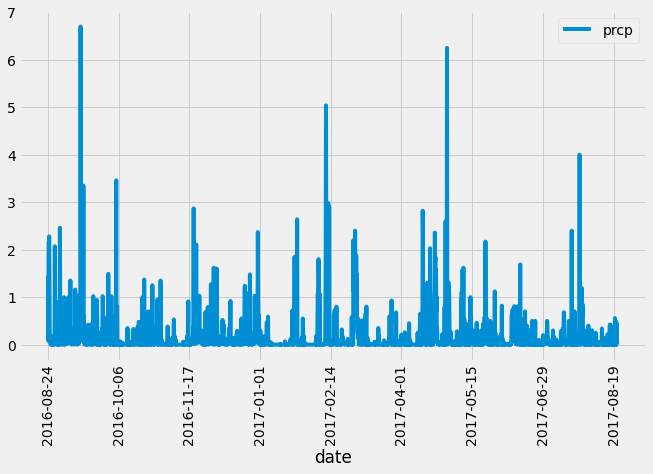

In [20]:
df.plot(rot=90,figsize=[10,6])
plt.show()

C:\Users\ym881\AppData\Local\Temp\ipykernel_52368\3890977624.py:5: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=8)


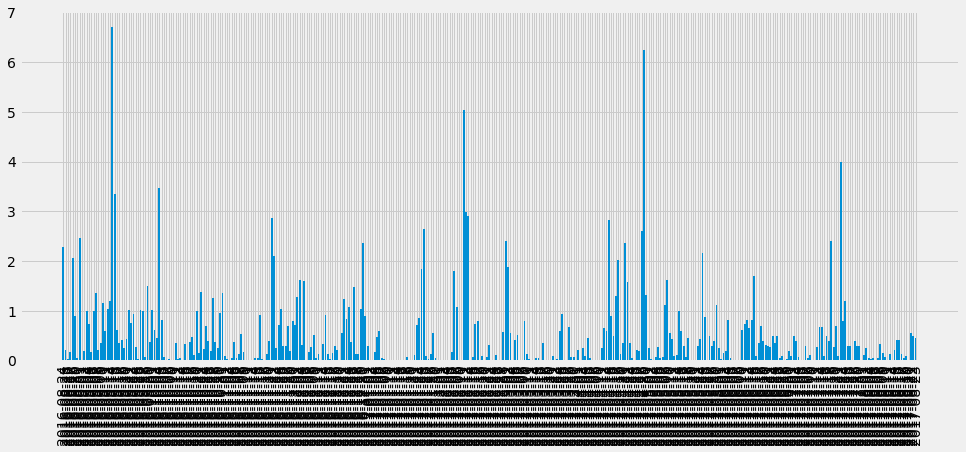

In [21]:
# Use Matplotlib to plot the data
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.bar(df.index,df.prcp)
plt.locator_params(nbins=8)
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
#i removed the null rows so my values may differ
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset
#columns: id, station, name, latitude, longitude, elevation, 
session.query(station.station).count()

9

In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
col=measurement.station
amt=func.count(col)
stat_ct=session.query(col, amt).group_by(col).order_by(desc(amt)).all()
stat_ct

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mini=func.min(measurement.tobs) 
maxi=func.max(measurement.tobs)
avg= func.avg(measurement.tobs)
session.query(mini, maxi, avg).filter(measurement.station == stat_ct[0][0]).first()

(54.0, 85.0, 71.66378066378067)

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
LastYearsTemps=session.query(measurement.station,measurement.date, measurement.tobs).filter(measurement.date>=pre_Year)\
.filter(measurement.station == stat_ct[0][0]).order_by(measurement.date).all()

In [27]:
LastYearsTemps_df=pd.DataFrame(LastYearsTemps)
LastYearsTemps_df.set_index('date',inplace=True)
LastYearsTemps_df.dropna(how='any',inplace=True)
LastYearsTemps_df.head()

,station,tobs
date,,
2016-08-23,USC00519281,77.0
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0


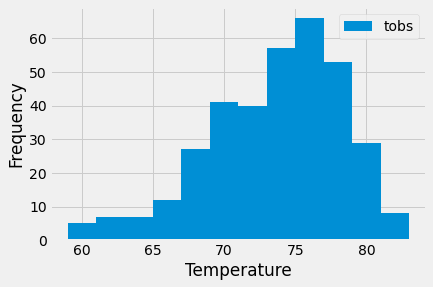

In [28]:
plt.hist(LastYearsTemps_df['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close session

In [29]:
# Close Session
session.close()